In [181]:

import findspark
findspark.init()
# Import SparkSession
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType,BooleanType
from pyspark.sql.functions import *

train_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date",DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("family", StringType(), True),
    StructField("Sales", StringType(), True),
    StructField("onpromotion", StringType(), True)
])

holiday_schema  = StructType([
    StructField("Date", DateType(), True),
    StructField("type", StringType(), True),
    StructField("locale", StringType(), True),
    StructField("locale_name", StringType(), True),
    StructField("description", StringType(), True),
    StructField("transferred", BooleanType(), True)
])

oil_schema = StructType([
    StructField("date", DateType(), True),
    StructField("dcoilwtico", StringType(), True),
    
])

stores_schema = StructType([
    StructField("store_nbr", IntegerType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("type", StringType(), True),
    StructField("cluster", StringType(), True),
    
])

test_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date", DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("family", StringType(), True),
    StructField("onpromotion", StringType(), True),
    
])

transactions_schema = StructType([
    StructField("date", DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("transactions", StringType(), True)
    
])



# Get path to directory (we all have unique paths to the repo)
__location__ = os.path.realpath(
    os.path.join(os.getcwd(), os.path.dirname('/home/robert/Downloads/store-sales-time-series-forecasting')))

# Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("dataProject") \
      .getOrCreate() 


# Read in data (this method felt easy to understand, but is verbose)
train_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/train.csv",schema=train_schema,header=True)

holidays_events_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/holidays_events.csv",
schema=holiday_schema,header=True)

oil_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/oil.csv",schema=oil_schema,header=True)

stores_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/stores.csv",schema=stores_schema,header=True)

test_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/test.csv",schema=test_schema,header=True)

transactions_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/transactions.csv",
schema=transactions_schema,header=True)



# If you want to see how it looks like
#train_df.show()
#holidays_events_df.show()
#oil_df.show()
#stores_df.show()
#test_df.show()
#transactions_df.show()


In [182]:

total_records = train_df.count()
first_date = train_df.head()['date']
last_date = train_df.tail(1)[0].date
total_days = last_date-first_date
store_nbr_id = stores_df.select("store_nbr").distinct().count()
family_unique = train_df.select("family").distinct().count()
stores_city = stores_df.select("city").distinct().count()
stores_state = stores_df.select("state").distinct().count()




In [183]:
print("Basic records:")
print("There are {} records, spanned from {} to {}.".format(total_records,first_date,last_date))
print("There are in total {}.".format(total_days))
print("There are {} distinct stores.".format(store_nbr_id))
print("There are in total {} product families.".format(family_unique))
print("Thre are {} cities and {} states.".format(stores_city,stores_state))

Basic records:
There are 3000888 records, spanned from 2013-01-01 to 2017-08-15.
There are in total 1687 days, 0:00:00.
There are 54 distinct stores.
There are in total 33 product families.
Thre are 22 cities and 16 states.


In [184]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))




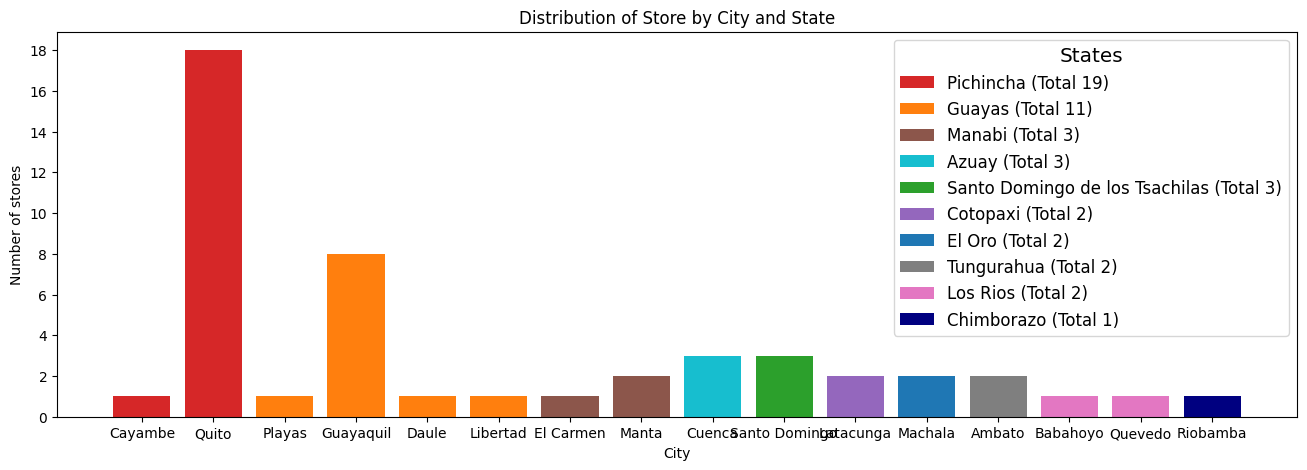

In [185]:
top_city_df = stores_df.groupBy('city').count().sort(desc("count"))
top_state_df = stores_df.groupBy('state').count().sort(desc("count"))
top_state = top_state_df.select(['state','count']).rdd.map(lambda r: (r[0],r[1])).collect()


stores_data_grouped = stores_df.groupBy(['state','city']).agg(count('city').alias('count'))

color = ["tab:red","tab:orange","tab:brown","tab:cyan","tab:green","tab:purple","tab:blue","tab:gray","tab:pink", "navy","darkred"]
fig, ax = plt.subplots( figsize=(16,5))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Distribution of Store by City and State")
ax.set_ylabel("Number of stores")
ax.set_xlabel("City")
custom_label=[]
custom_legend = []
for i in range(0,10):
    u = stores_data_grouped.filter(stores_data_grouped.state == top_state[i][0])
    ax.bar(u.select(['city']).rdd.map(lambda r: r[0]).collect(), 
    u.select(['count']).rdd.map(lambda r: r[0]).collect(),color=color[i])
    custom_label.append ( Patch(facecolor=color[i])  )
    custom_legend.append( top_state[i][0] + " (Total {})".format(top_state[i][1]))
ax.legend(custom_label, custom_legend, fontsize="large", labelcolor="black", 
          fancybox=True, title = "States", title_fontsize = "x-large")
plt.show()




In [186]:
sales_grouped = train_df.groupBy(['store_nbr','date']).agg(sum('sales').alias('sales'))
#sales_grouped.show()
sales_by_store_id = list()

for store in range(1,store_nbr_id+1):
    sales_by_store_id.append({'store':store,'sale':
    sales_grouped.filter(sales_grouped.store_nbr == store).select(avg("sales").alias('sales')).first()['sales'],
    'city':stores_df.filter(stores_df.store_nbr == store).select('city').first()['city'],
    'city-id':stores_df.filter(stores_df.store_nbr == store).select('city').first()['city']+"-{}".format(store),
    'state':stores_df.filter(stores_df.store_nbr == store).select('state').first()['state'],
    'type':stores_df.filter(stores_df.store_nbr == store).select('type').first()['type'],
    'cluster':stores_df.filter(stores_df.store_nbr == store).select('cluster').first()['cluster']})
sales_by_store_id = spark.createDataFrame(sales_by_store_id)
#sales_by_store_id.show()

In [187]:
from numpy import select


top_city = top_city_df.select(['city']).rdd.map(lambda r: r[0]).collect()

sales_by_city = list()
top_state = top_state_df.select(['state','count']).rdd.map(lambda r: (r[0],r[1])).collect()



for city_ in top_city:
    sales_by_city.append({'city':city_,
    'sum':sales_by_store_id.filter(sales_by_store_id.city == city_).agg({'sale':'sum'}).first()['sum(sale)'],
    'mean':sales_by_store_id.filter(sales_by_store_id.city == city_).agg({'sale':'avg'}).first()['avg(sale)']})
sales_by_city = spark.createDataFrame(sales_by_city)
#sales_by_city.show()


In [188]:
sales_by_store_id = sales_by_store_id.orderBy(['sale'],ascending=[False])
sales_by_city_sum = sales_by_city.orderBy(['sum'],ascending=[False])



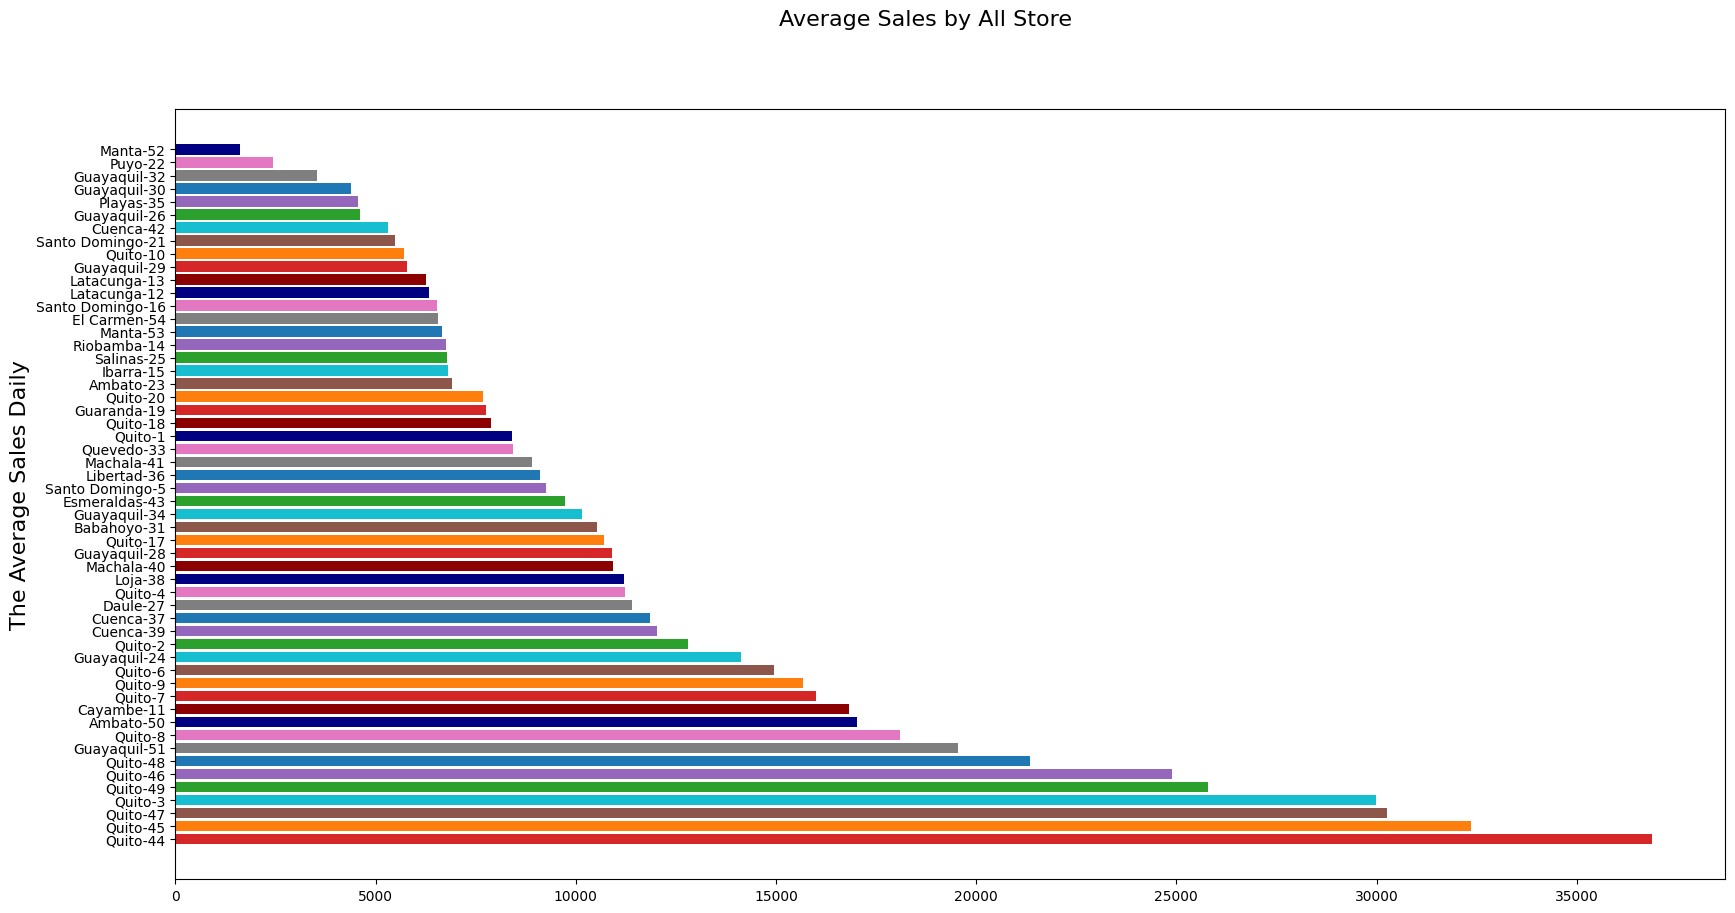

In [189]:
# Ploting
figsize = (20,10)
fig, ax0 = plt.subplots(figsize=figsize)
city_id = [val[0] for val in sales_by_store_id.select('city-id').collect()]
sale = [val[0] for val in sales_by_store_id.select('sale').collect()]
plt.barh(city_id,sale,color=color, align='center')
plt.suptitle("Average Sales by All Store",  fontsize=16, ha='center')
ax0.set_ylabel('The Average Sales Daily',  fontsize=16);

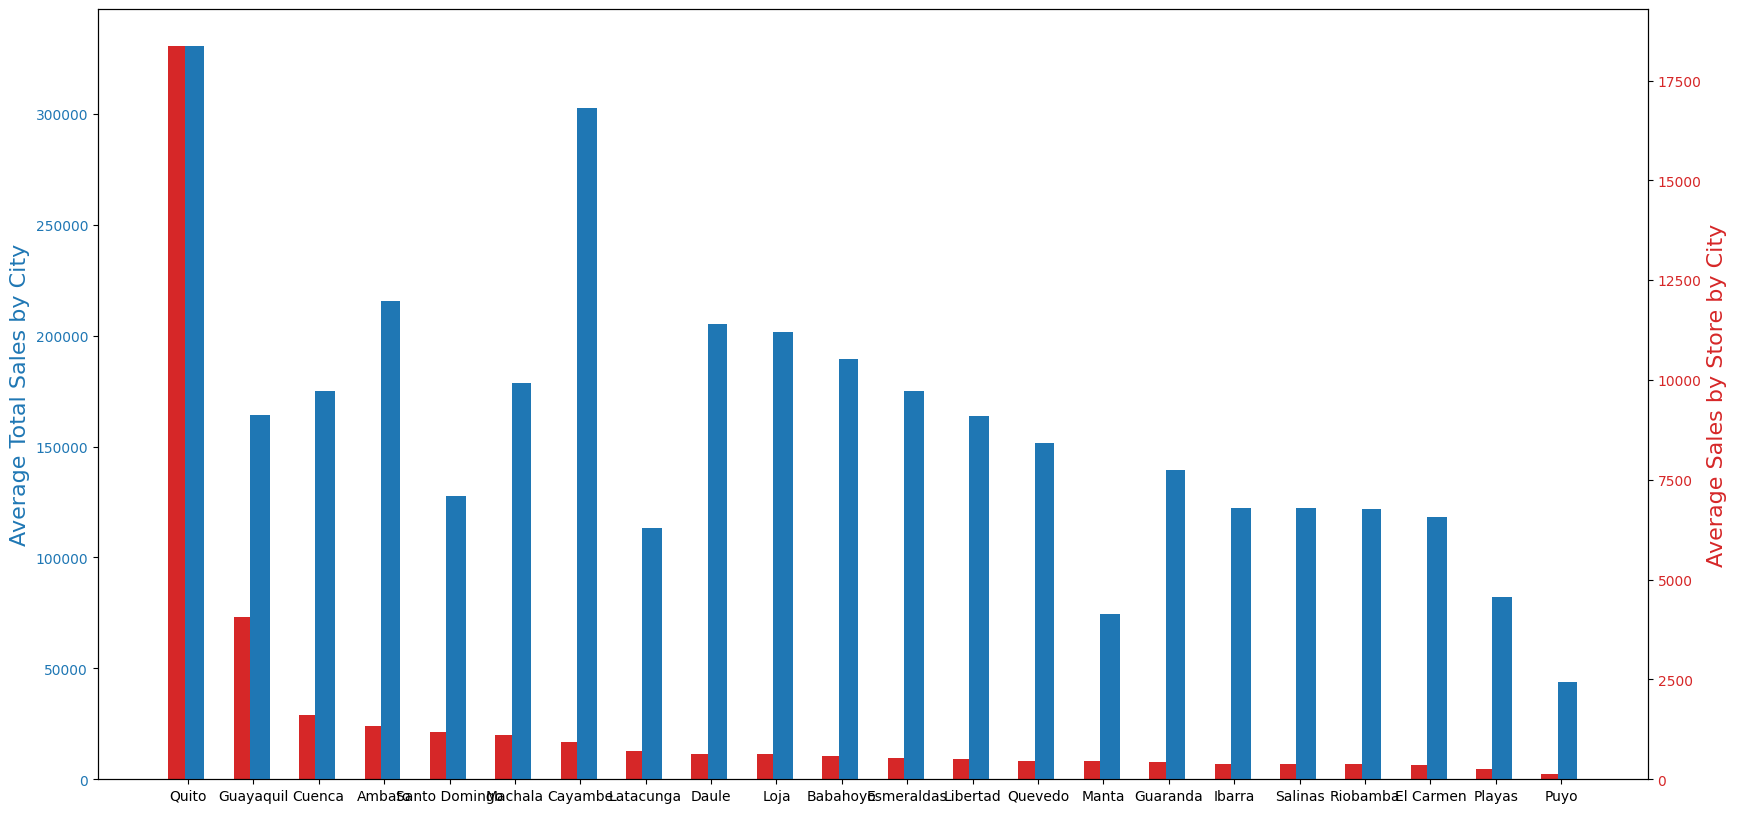

In [190]:
color2 = "tab:red"
color1 = "tab:blue"
fig,ax1= plt.subplots(figsize=figsize)
sum = [val[0] for val in sales_by_city_sum.select('sum').collect()]

mean = [val[0] for val in sales_by_city_sum.select('mean').collect()]
cities = [val[0] for val in sales_by_city_sum.select('city').collect()]
x = np.arange(len(cities))
plt.bar(x-0.1,sum,color=color2,width=0.4)
ax2 = ax1.twinx()

plt.bar(x+0.1,mean,color=color1,width=0.3)
plt.xticks(x,cities)

############# Style Set up ###############
ax1.set_ylabel('Average Total Sales by City', color=color1, fontsize=16)
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('Average Sales by Store by City', color=color2, fontsize=16)  
ax2.tick_params(axis='y', labelcolor=color2)

In [191]:
from pyspark.sql.window import Window
from pyspark.sql import functions as func

sales_grouped = train_df.groupBy('date').agg(func.sum('sales').alias('sales'))
sales_grouped = sales_grouped.orderBy('date',ascending=[True])
sales_grouped = sales_grouped.withColumn('year',year(sales_grouped.date))
sales_grouped = sales_grouped.withColumn('quarter',quarter(sales_grouped.date))
sales_grouped = sales_grouped.withColumn('month',month(sales_grouped.date))
sales_grouped = sales_grouped.withColumn("partition",lit("1"))

sales_grouped.show()

+----------+------------------+----+-------+-----+---------+
|      date|             sales|year|quarter|month|partition|
+----------+------------------+----+-------+-----+---------+
|2013-01-01|2511.6189990000003|2013|      1|    1|        1|
|2013-01-02|496092.41794400004|2013|      1|    1|        1|
|2013-01-03| 361461.2311239999|2013|      1|    1|        1|
|2013-01-04|354459.67709269986|2013|      1|    1|        1|
|2013-01-05| 477350.1212289998|2013|      1|    1|        1|
|2013-01-06| 519695.4010879999|2013|      1|    1|        1|
|2013-01-07| 336122.8010659999|2013|      1|    1|        1|
|2013-01-08|318347.77798099996|2013|      1|    1|        1|
|2013-01-09|302530.80901799985|2013|      1|    1|        1|
|2013-01-10|258982.00304899988|2013|      1|    1|        1|
|2013-01-11| 289737.6850845001|2013|      1|    1|        1|
|2013-01-12| 403258.2120105001|2013|      1|    1|        1|
|2013-01-13| 464638.5479980001|2013|      1|    1|        1|
|2013-01-14|293348.36207

In [192]:

w=Window().partitionBy("partition").orderBy("date")
sales_grouped = sales_grouped.withColumn('rank', func.dense_rank().over(w))

w7 = (Window().partitionBy("partition").orderBy("rank").rangeBetween(-6,0))

sales_grouped = sales_grouped.select("*", (func.mean("sales").over(w7)).alias("L7D_moving_avg")).drop("rank")

sales_grouped = sales_grouped.withColumn('rank', func.dense_rank().over(w))

w30 = (Window().partitionBy("partition").orderBy("rank").rangeBetween(-29,0))

sales_grouped = sales_grouped.select("*", (func.mean("sales").over(w30)).alias("L30D_moving_avg")).drop("rank")

sales_grouped = sales_grouped.withColumn('rank', func.dense_rank().over(w))

w365 = (Window().partitionBy("partition").orderBy("rank").rangeBetween(-364,0))

sales_grouped = sales_grouped.select("*", (func.mean("sales").over(w365)).alias("L365D_moving_avg")).drop("rank")




([<matplotlib.patches.Wedge at 0x7fbc3f08e530>,
 [Text(-0.7415678898878013, 0.8124512691154799, 'Quarter 1'),
  Text(-0.867813649231348, -0.6759433927539873, 'Quarter 2'),
  Text(0.6446033631735065, -0.8913397243393815, 'Quarter 3'),
  Text(0.8383500546044391, 0.7121581186399087, 'Quarter 4')],
 [Text(-0.40449157630243704, 0.44315523769935267, '24%'),
  Text(-0.4733528995807352, -0.36869639604762944, '24%'),
  Text(0.35160183445827625, -0.48618530418511713, '25%'),
  Text(0.45728184796605764, 0.3884498828944956, '28%')])

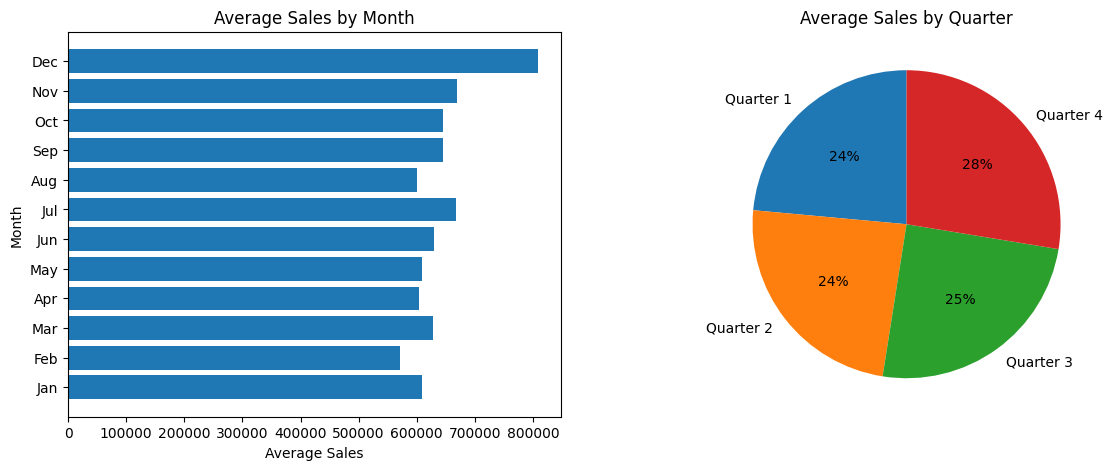

In [193]:
figsize = (14,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
df_plot_month = sales_grouped.groupBy('month').agg(func.avg('sales').alias('sales'))
df_plot_month = df_plot_month.orderBy(['month'],ascending=[True])

sales_month = [val[0] for val in df_plot_month.select('sales').collect()]
x_axis = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax1.set(title="Average Sales by Month")
ax1.set(ylabel="Month", xlabel="Average Sales")
ax1.barh(x_axis,sales_month)
ax2.set(title="Average Sales by Quarter")
df_plot_quarter = sales_grouped.groupBy('quarter').agg(func.avg('sales').alias('sales'))
df_plot_quarter = df_plot_quarter.orderBy(['sales'],ascending=[True])


sales_quarter = [val[0] for val in df_plot_quarter.select('sales').collect()]

ax2.pie(sales_quarter,autopct='%1.f%%',startangle=90,labels=["Quarter 1","Quarter 2","Quarter 3","Quarter 4"])


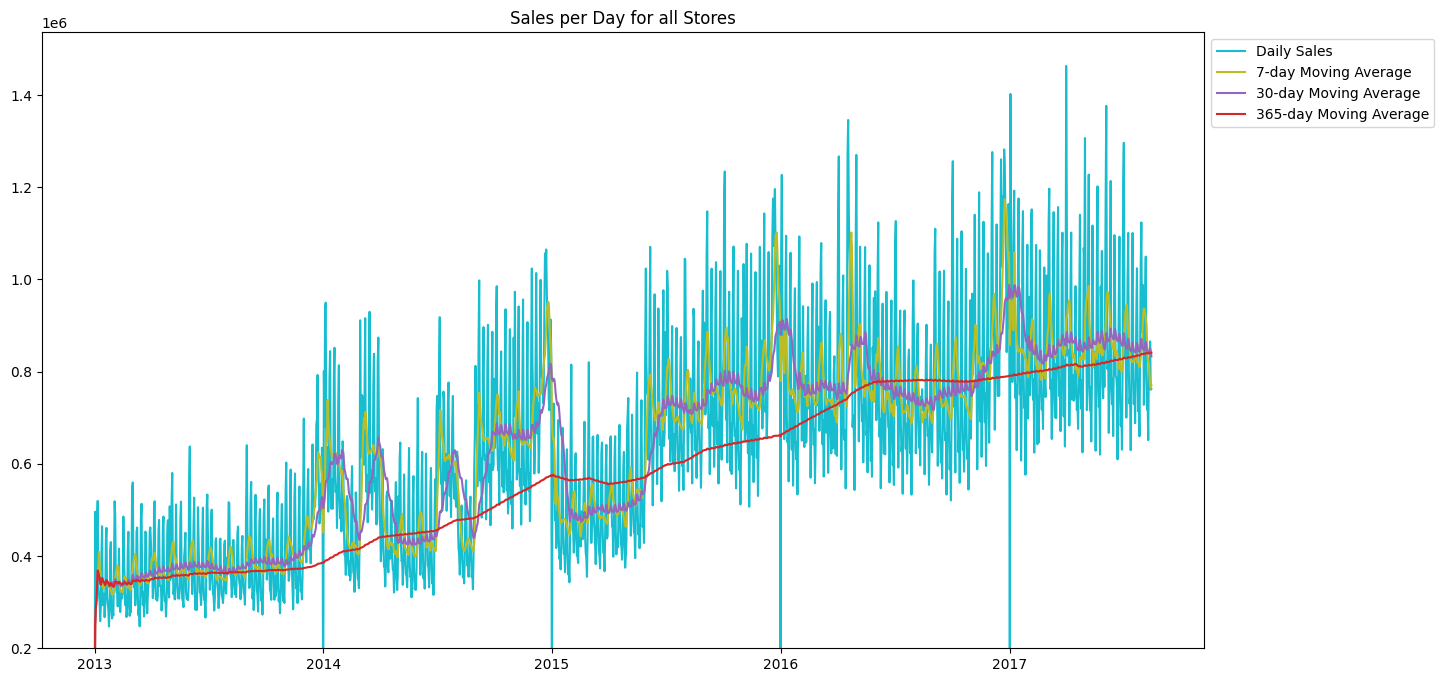

In [194]:
figsize = (15,8)
fig, ax = plt.subplots(figsize=figsize)
all_dates = [val[0] for val in sales_grouped.select('date').collect()]
normal_sales = [val[0] for val in sales_grouped.select('sales').collect()]
sales7 = [val[0] for val in sales_grouped.select('L7D_moving_avg').collect()]
sales30 = [val[0] for val in sales_grouped.select('L30D_moving_avg').collect()]

sales365 = [val[0] for val in sales_grouped.select('L365D_moving_avg').collect()]
ax.plot(all_dates,normal_sales,color="tab:cyan")
ax.plot(all_dates,sales7,color='tab:olive')
ax.plot(all_dates,sales30,color="tab:purple")
ax.plot(all_dates,sales365,color='tab:red')


ax.legend(["Daily Sales","7-day Moving Average","30-day Moving Average","365-day Moving Average"],bbox_to_anchor=(1.0, 1.0))
ax.set(ylim=2e5, title="Sales per Day for all Stores")

plt.show()


In [195]:

df_plot_2013 = sales_grouped.filter(sales_grouped.year == "2013").select(['date','sales','L7D_moving_avg'])
df_plot_2014 = sales_grouped.filter(sales_grouped.year == "2014").select(['date','sales','L7D_moving_avg'])
df_plot_2015 = sales_grouped.filter(sales_grouped.year == "2015").select(['date','sales','L7D_moving_avg'])
df_plot_2016 = sales_grouped.filter(sales_grouped.year == "2016").select(['date','sales','L7D_moving_avg'])
df_plot_2017 = sales_grouped.filter(sales_grouped.year == "2017").select(['date','sales','L7D_moving_avg'])

sales_2013 = [val[0] for val in df_plot_2013.select('sales').collect()]
sales_7_2013 = [val[0] for val in df_plot_2013.select('L7D_moving_avg').collect()]
dates_2013 = [val[0] for val in df_plot_2013.select('date').collect()]

sales_2014 = [val[0] for val in df_plot_2014.select('sales').collect()]
sales_7_2014 = [val[0] for val in df_plot_2014.select('L7D_moving_avg').collect()]
dates_2014 = [val[0] for val in df_plot_2014.select('date').collect()]

sales_2015 = [val[0] for val in df_plot_2015.select('sales').collect()]
sales_7_2015 = [val[0] for val in df_plot_2015.select('L7D_moving_avg').collect()]
dates_2015 = [val[0] for val in df_plot_2015.select('date').collect()]

sales_2016 = [val[0] for val in df_plot_2016.select('sales').collect()]
sales_7_2016 = [val[0] for val in df_plot_2016.select('L7D_moving_avg').collect()]
dates_2016 = [val[0] for val in df_plot_2016.select('date').collect()]

sales_2017 = [val[0] for val in df_plot_2017.select('sales').collect()]
sales_7_2017 = [val[0] for val in df_plot_2017.select('L7D_moving_avg').collect()]
dates_2017 = [val[0] for val in df_plot_2017.select('date').collect()]



[Text(0.5, 1.0, '2017 Sales per Day for all Stores')]

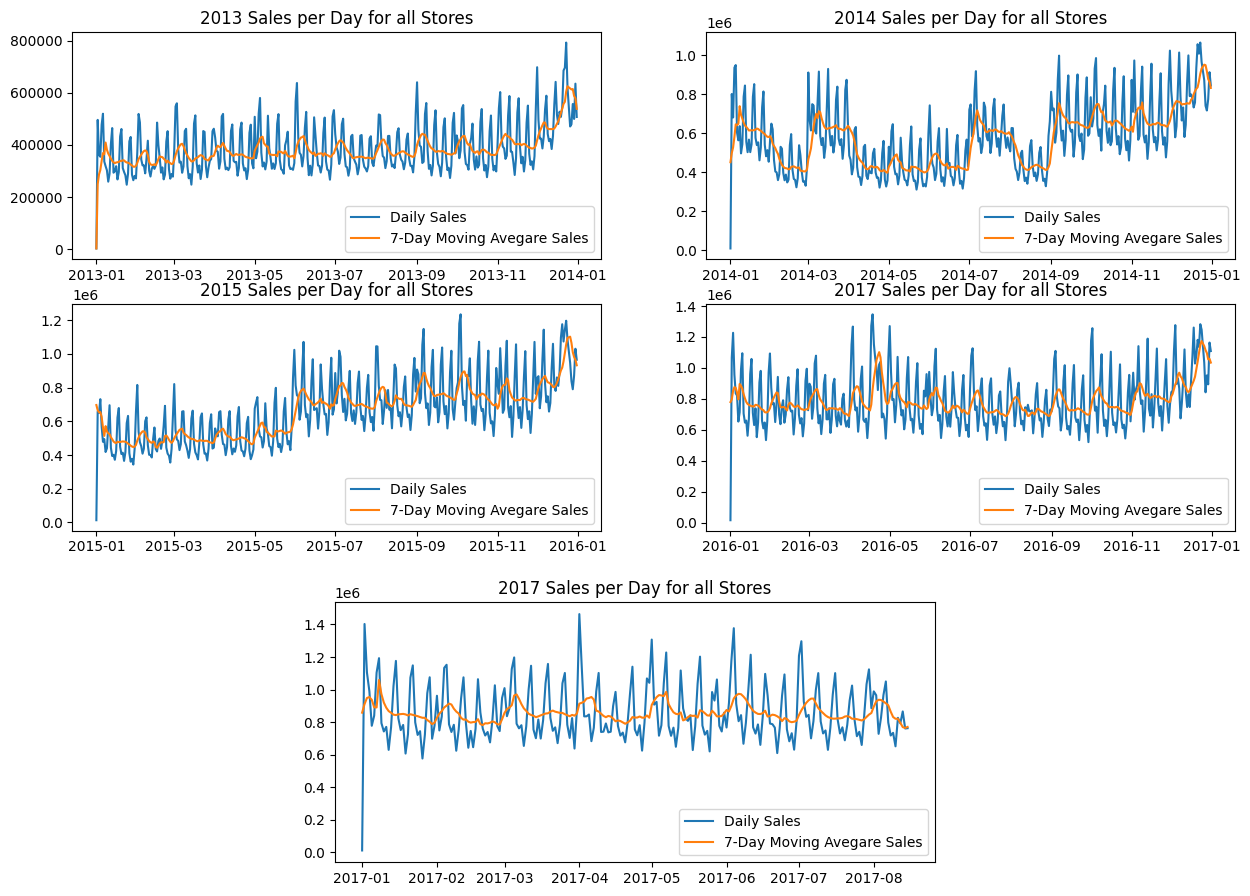

In [196]:
figsize = (16,5)
fig, ax = plt.subplots(3,2, figsize=(15,10))
ax[2][1].set_visible(False)
ax[2][0].set_position([0.30,0.05,0.4,0.26])


ax[0][0].plot(dates_2013,sales_2013)
ax[0][0].plot(dates_2013,sales_7_2013)

ax[0][0].legend(["Daily Sales","7-Day Moving Avegare Sales"])
ax[0][0].set(title="2013 Sales per Day for all Stores")

ax[0][1].plot(dates_2014,sales_2014)
ax[0][1].plot(dates_2014,sales_7_2014)

ax[0][1].legend(["Daily Sales","7-Day Moving Avegare Sales"])
ax[0][1].set(title="2014 Sales per Day for all Stores")

ax[1][0].plot(dates_2015,sales_2015)
ax[1][0].plot(dates_2015,sales_7_2015)

ax[1][0].legend(["Daily Sales","7-Day Moving Avegare Sales"])
ax[1][0].set(title="2015 Sales per Day for all Stores")

ax[1][1].plot(dates_2016,sales_2016)
ax[1][1].plot(dates_2016,sales_7_2016)

ax[1][1].legend(["Daily Sales","7-Day Moving Avegare Sales"])
ax[1][1].set(title="2017 Sales per Day for all Stores")

ax[2][0].plot(dates_2017,sales_2017)
ax[2][0].plot(dates_2017,sales_7_2017)

ax[2][0].legend(["Daily Sales","7-Day Moving Avegare Sales"])
ax[2][0].set(title="2017 Sales per Day for all Stores")



[Text(0.5, 1.0, 'Anuual Sales Seasonal plot (year/DayofYear)')]

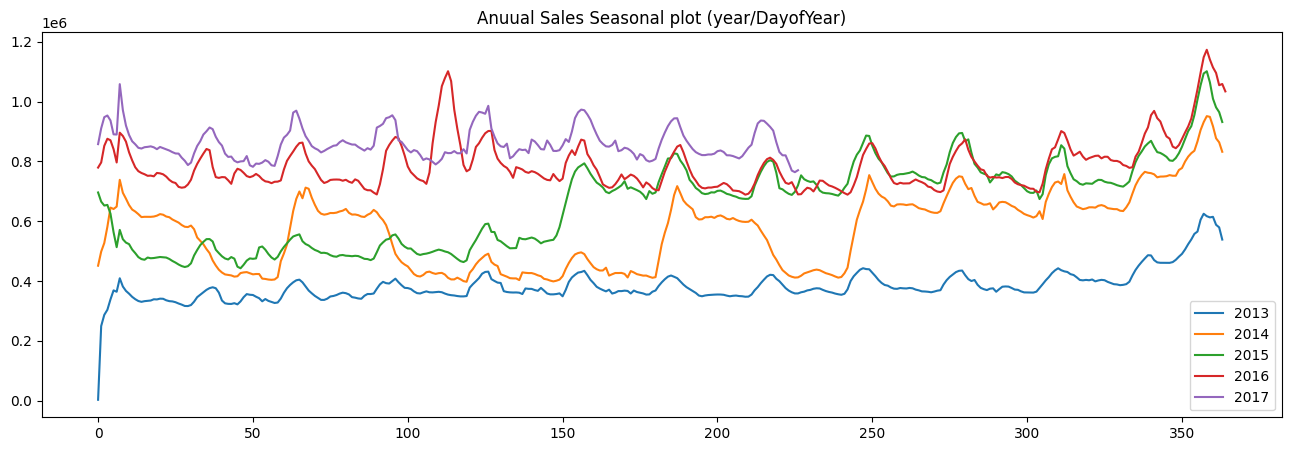

In [197]:
figsize = (16,5)
fig, ax = plt.subplots(figsize=figsize)

x = np.arange(0,len(dates_2014))
x1 = np.arange(0,len(dates_2016))
x2 = np.arange(0,len(dates_2017))
ax.plot(x,sales_7_2013)
ax.plot(x,sales_7_2014)
ax.plot(x,sales_7_2015)
ax.plot(x1,sales_7_2016)
ax.plot(x2,sales_7_2017)


ax.legend(["2013","2014","2015","2016","2017"])
ax.set(title="Anuual Sales Seasonal plot (year/DayofYear)")